In [1]:
__author__ = "Amir Hejazi"
__date__ = "07/7/2021"

## Required libraries for nvidia gpu
######################################################
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
# config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.2
session = InteractiveSession(config=config)

## Required libraries for the code
######################################################
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Nadam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
from math import sqrt
from sklearn import utils
from itertools import product
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, time, sys, math
import random as rn

import warnings
warnings.filterwarnings("ignore")

In [2]:
def seed(val=0):   
    tf.random.set_seed(val)
    np.random.seed(val)
    rn.seed(val)
    os.environ['PYTHONHASHSEED'] = str(val)
    utils.check_random_state(val)

In [3]:
# Get the data
######################################################
pd.set_option("display.max_rows",
              None,
              "display.max_columns",
              None)
df = pd.read_csv('data/data.csv')

In [4]:
print(df.head)

<bound method NDFrame.head of           STATION               NAME        DATE   TMAX  TMIN   TOBS
0     USC00047965  SANTA ROSA, CA US  2010-05-01   77.0  45.0   75.0
1     USC00047965  SANTA ROSA, CA US  2010-05-02   82.0  49.0   81.0
2     USC00047965  SANTA ROSA, CA US  2010-05-03   79.0  49.0   77.0
3     USC00047965  SANTA ROSA, CA US  2010-05-04   75.0  46.0   74.0
4     USC00047965  SANTA ROSA, CA US  2010-05-05   75.0  48.0   70.0
5     USC00047965  SANTA ROSA, CA US  2010-05-06   75.0  41.0   73.0
6     USC00047965  SANTA ROSA, CA US  2010-05-07   71.0  39.0   68.0
7     USC00047965  SANTA ROSA, CA US  2010-05-08   72.0  43.0   66.0
8     USC00047965  SANTA ROSA, CA US  2010-05-09   65.0  45.0   59.0
9     USC00047965  SANTA ROSA, CA US  2010-05-10   63.0  46.0   50.0
10    USC00047965  SANTA ROSA, CA US  2010-05-11   67.0  37.0   67.0
11    USC00047965  SANTA ROSA, CA US  2010-05-12   72.0  44.0   70.0
12    USC00047965  SANTA ROSA, CA US  2010-05-13   73.0  45.0   71.0
13  

In [5]:
tempMaxData = df.filter(['DATE','TMAX'])
print(tempMaxData.isna().any())

DATE    False
TMAX     True
dtype: bool


In [6]:
tempMaxData.tail()

,DATE,TMAX
2196,2021-05-25,83.0
2197,2021-05-26,83.0
2198,2021-05-27,87.0
2199,2021-05-28,87.0
2200,2021-05-30,84.0


In [7]:
# Setting the index
tempMaxData.set_index('DATE', inplace=True)

# Dropping any NaNs
tempMaxData.dropna(inplace=True)
tempMaxData.tail()
print(tempMaxData.isna().any())

TMAX    False
dtype: bool


<AxesSubplot:title={'center':'Maximum Temperature'}, xlabel='DATE'>

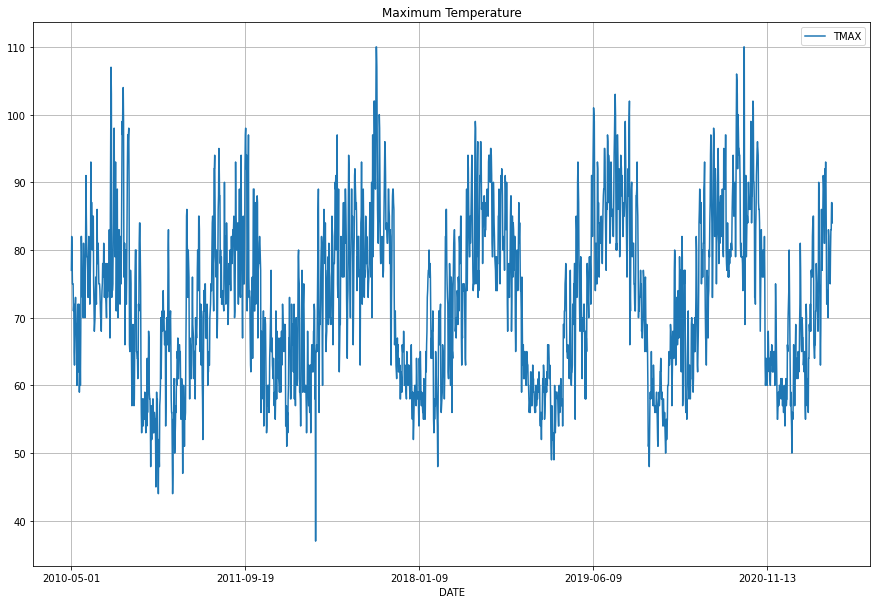

In [8]:
tempMaxData.plot(figsize=(15,10),title='Maximum Temperature', grid=True)

In [9]:
scaler = MinMaxScaler(feature_range=(-1,1))
tempMaxDataScaled = scaler.fit_transform(tempMaxData)

In [10]:
# split the dataset into train and test data
train_data_length = math.ceil(len(tempMaxDataScaled) * 0.74)
train, test = tempMaxDataScaled[0:train_data_length],\
              tempMaxDataScaled[train_data_length:]

In [11]:
"""
Lift Chart:
"""
# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.title('Lift Chart')
    plt.ylabel('Output')
    plt.xlabel('Samples')
    plt.legend()
    plt.legend()
    plt.grid()
#     plt.show()

In [12]:
def plot(prediction,y_test,history):

    plt.figure(1, figsize=(14,11))
    plt.subplot(211)
    plt.plot(history.history['loss'],'c',label='loss')
    plt.plot(history.history['val_loss'],'r',label='validation loss')
    plt.title('System loss', fontsize=10)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(212)
    plt.plot(history.history['accuracy'], '-b', label='Accuracy')
    plt.plot(history.history['val_accuracy'], '--r', label='Val-Accuracy')
    plt.title('System Accuracy', fontsize=10)
    plt.ylabel('Accuracy')
    plt.xlabel('epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(2,(14,11))
    plt.subplot(211)
    chart_regression(prediction.flatten(),y_test) 
    
    if (len(y_test) <= 150):
        length = len(y_test)
    else:
        length = 150
    start = len(prediction) - length
    end   = len(prediction)
    
    plt.subplot(212)
    plt.plot(range(start,end), 
                (prediction[start:end,:]), 
                '--r',
                label='Prediction') 
    plt.plot(range(start,end), 
                y_test[start:end,:], 
                '-b',
                label='Measured')  
    plt.title('Measured V.S. Predicted values')
    plt.xlabel('samples')
    plt.ylabel('Max Temp')
    plt.grid(True)
    plt.legend()   
    plt.show()

In [13]:
####################################################     
# Setting Parameters 
####################################################
parameters = OrderedDict(
        gru_units=[2**7],  
        batch_size=[16], 
        epochs_num=[32], 
        gru_layers=[3],  
        seed_value=[0], 
        window = [181]) 

In [14]:
####################################################################### 
# Create a list of iterables that we can pass to the product functions.
####################################################################### 
gu = []
bs = []
ep = []   
gl = []
sd = []
wd = []

param_values = [v for v in parameters.values()]

for gru_units, batch_size, epochs_num, gru_layers, seed_value, window in product(*param_values): 
    gu.append(gru_units)
    bs.append(batch_size)
    ep.append(epochs_num)
    gl.append(gru_layers)
    sd.append(seed_value)
    wd.append(window)
    
dd = {
    'gru_units':gu,
    'batch_size':bs,
    'epochs':ep, 
    'gru_layers':gl,
    'seed_value':sd,
    'window':wd
    }

results = pd.DataFrame(dd)
print(results)

   gru_units  batch_size  epochs  gru_layers  seed_value  window
0        128          16      32           3           0     181


In [15]:
def create_training_dataset(train, window):
    x_train = []
    y_train = []
    for i in range(window, len(train)):
        x_train.append(train[i-window:i,:])
        y_train.append(train[i])
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    return x_train, y_train

In [16]:
def model(nadam_lr=0.0001, dropout_rate=0.001):
    
    counter = 0
    for gru_units, batch_size, epochs_num, gru_layers, seed_value, window in product(*param_values):

        seed(seed_value)
              
        #############################################
        # Create x, y train and test dataset
        ############################################# 
        x_train, y_train = create_training_dataset(train, window)
        x_test, y_test = create_training_dataset(test, window)

        ####################################################
        # Model
        ####################################################
        model = Sequential() 
        
        # Input layer
        model.add(Bidirectional(GRU(units=int(gru_units), return_sequences=True), 
                                input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(dropout_rate))
        
        # Hidden layer(s)
        for _ in range(gru_layers):
            model.add(Bidirectional(GRU(units=gru_units, return_sequences=True)))
            model.add(Dropout(dropout_rate))
        
        model.add(Bidirectional(GRU(units=gru_units, return_sequences=False)))
        model.add(Dropout(dropout_rate))

        model.add(Dense(units=int(gru_units/2))) 
        model.add(Dropout(dropout_rate))

        # Output layer
        model.add(Dense(units=1))            

        ## Optimizer/compile the model
        ######################################################
        model.compile(optimizer=Nadam(lr=nadam_lr), 
                      loss='huber_loss',
                      metrics=['accuracy'])
        
        model.summary()

        ## Train The Network
        ######################################################
        callback = [EarlyStopping(monitor='loss', 
                                  mode='auto', 
                                  min_delta=0.001, 
                                  patience=11,
                                  verbose=1,
                                  restore_best_weights=True)]
      
        history = model.fit(x_train,
                            y_train,
                            batch_size=batch_size,
                            epochs=epochs_num,
                            validation_data=(x_test, y_test),
                            callbacks=callback,
                            shuffle=True)

        ## Prediction
        ######################################################
        prediction = model.predict(x_test)
        prediction = scaler.inverse_transform(prediction)
        y_test = scaler.inverse_transform(y_test)    
        
        # ## calculate the RMSE
        # ######################################################
        rmse = sqrt(mean_squared_error(y_test, prediction))
        
        ## Print the models parameters.
        ######################################################
        print('Iteration # =', counter,
            '\ngru_units =', gru_units, 
            '\nepochs_num =', epochs_num,
            '\nbatch_size =', batch_size,
            '\ngru_layers =', gru_layers,
            '\nseed_value =', seed_value,
            '\nwindow =', window,
            '\nRMSE =', rmse)
        
        ## plot the data
        ######################################################
        plot(prediction,y_test,history)
        counter+=1
        
        tf.keras.backend.clear_session()
        del model
        del prediction 
        del rmse
        del history
        del x_train, y_train
        del x_test, y_test 


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 181, 256)          100608    
_________________________________________________________________
dropout (Dropout)            (None, 181, 256)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 181, 256)          296448    
_________________________________________________________________
dropout_1 (Dropout)          (None, 181, 256)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 181, 256)          296448    
_________________________________________________________________
dropout_2 (Dropout)          (None, 181, 256)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 181, 256)          2

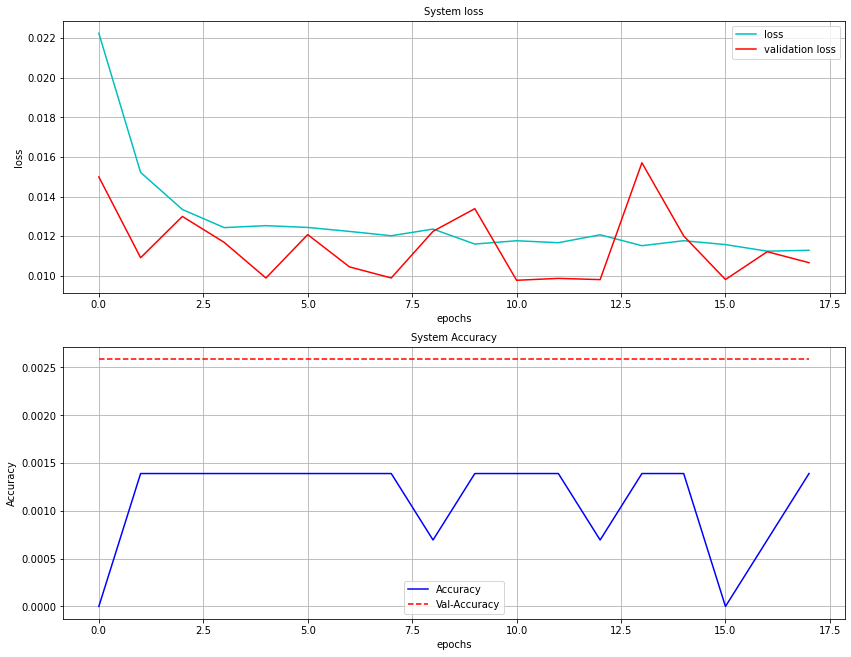

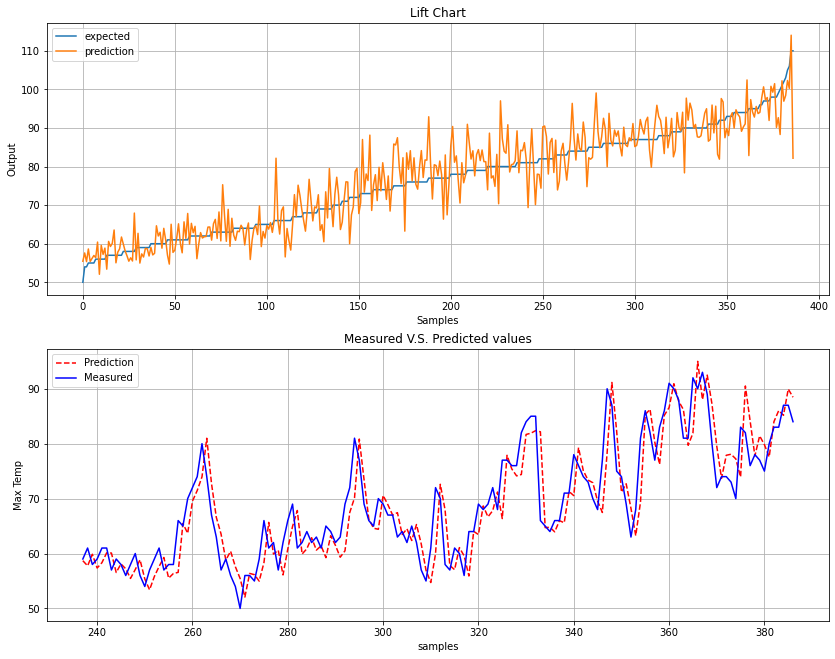

Total runtime: 283.85307812690735


In [17]:
start_time = time.time()
model(0.001318,0.0305)
time_took = time.time() - start_time

print(f"Total runtime: {time_took}")